### Metadata

In [1]:
%cd ..

/Users/davidrestrepo/Data Fusion/DF-DM


In [2]:
from src.Preprocessing.time_series_preprocessing import get_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
from src.Preprocessing.time_series_preprocessing import read_static, read_features
from src.Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np
import random
import tensorflow as tf
import torch

def set_all_seeds(seed):
    """
    Set seed for reproducibility in different libraries.
    :param seed: An integer representing the seed value.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # Numpy library
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

    # TensorFlow
    tf.random.set_seed(seed)
    if tf.__version__[0] == '2':
        # For TensorFlow 2.x, additionally set the global random seed
        tf.compat.v1.set_random_seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # If using GPU with PyTorch, set additional seeds
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU

In [3]:
DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
cohort = 'cities.csv'

In [4]:
cities = pd.read_csv(DIR_PATH + cohort)
cities

,lat,lng,Municipality,Municipality code,ISO
0,6.2447,-75.5748,Medellín,5001,CO-ANT
1,3.4400,-76.5197,Cali,76001,CO-VAC
2,4.5781,-74.2144,Soacha,25754,CO-CUN
3,4.1425,-73.6294,Villavicencio,50001,CO-MET
4,1.2136,-77.2811,Pasto,52001,CO-NAR
5,10.9639,-74.7964,Barranquilla,8001,CO-ATL
6,7.1186,-73.1161,Bucaramanga,68001,CO-SAN
7,4.4378,-75.2006,Ibagué,73001,CO-TOL
8,2.4411,-76.6061,Popayán,19001,CO-CAU
9,7.9075,-72.5047,Cúcuta,54001,CO-NSA


##### Constants

In [5]:
""" Read Dataset:"""
image_embeddings = 'Embeddings/violence/variational_autoencoder_ResNet50V2__224_1024_3Bands.csv'
media_data = None # 'datasets/violence_prediction/media_data.csv'
static = 'datasets/violence_prediction/metadata_labels.csv'

DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
labels = pd.read_csv(DIR_PATH + file)

# Get list of municipalities:
cohort = 'cities.csv'
cities = pd.read_csv(DIR_PATH + cohort)
Municipalities = cities.Municipality.values

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

seed = 1
n_tests = 3

### Read and Preprocess the Data

#### Read the Data

In [6]:
# Read dataset
dengue_df = [get_dataset(labels_path=labels, embeddings_path=image_embeddings, municipality=Municipality, temp_prec=media_data, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Cúcuta onl

list

#### Train-Test Split

In [7]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
    

The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)


#### Normalize the Data

In [8]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [9]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

train_df[1].head()

0         1         2         3         4         5  \
Cali 201751 -0.385984 -0.100018  0.960533 -0.354473 -0.055128  0.338641   
     201752 -1.282319  0.666823 -1.024877 -0.480813 -0.802065 -0.330924   
     201801 -1.683890 -0.849583 -0.568381 -0.754841 -0.526665 -0.624165   
     201802 -1.358373  0.762772  1.410340 -1.061159 -1.731456  0.779795   
     201803 -1.272016  0.064206  0.432831  0.543075 -0.019783  0.439341   

                    6         7         8         9  ...  \
Cali 201751 -0.402330  0.098669 -0.257309  0.564616  ...   
     201752 -0.888206  0.818039 -1.359011 -1.455692  ...   
     201801 -0.859691 -1.089362 -0.399346  0.093649  ...   
     201802 -0.438423  0.195660  0.357885 -0.166132  ...   
     201803  0.005068  0.547456 -0.609698 -0.443303  ...   

             Buildingstratification1(%)  Buildingstratification2(%)  \
Cali 201751                   -0.703859                   -0.409825   
     201752                   -0.703859                   -0.409825   
     201801                   -0.703859                   -0.409825   
     201802                   -0.703859                   -0.409825   
     201803                   -0.703859                   -0.409825   

             Buildingstratification3(%)  Buildingstratification4(%)  \
Cali 201751                    0.691928                    0.172051   
     201752                    0.691928                    0.172051   
     201801                    0.691928                    0.172051   
     201802                    0.691928                    0.172051   
     201803                    0.691928                    0.172051   

             Buildingstratification5(%)  Buildingstratification6(%)  \
Cali 201751                    1.859602                    0.625183   
     201752                    1.859602                    0.625183   
     201801                    1.859602                    0.625183   
     201802                    1.859602                    0.625183   
     201803                    1.859602                    0.625183   

             NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
Cali 201751                 0.096275              0.412343    1.747972   
     201752                 0.096275              0.412343    1.747972   
     201801                 0.096275              0.412343    1.747972   
     201802                 0.096275              0.412343    1.747972   
     201803                 0.096275              0.412343    1.747972   

               Labels  
Cali 201751 -0.364738  
     201752 -0.864653  
     201801  0.695082  
     201802  0.175170  
     201803  0.495116  

[5 rows x 1051 columns]

In [10]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
Cali 202152 -1.016940 -0.171893  1.499964  1.559776 -0.664243  0.744996   
     202201 -1.988324 -0.192517  0.439087  2.465333  0.879253  0.172476   
     202202 -0.097451 -0.566649  0.281780  0.874312  1.611616  0.962811   
     202203  0.406234 -0.844834  0.074867  2.037769  0.470359 -1.585948   
     202204  0.159908  0.632045 -0.867618  0.504921 -0.079367  0.348996   

                    6         7         8         9  ...  \
Cali 202152 -0.816341  2.673785 -0.330811  1.899529  ...   
     202201 -0.090059 -1.937555  0.742771 -0.458013  ...   
     202202  3.301857  0.114423  0.709939  0.907148  ...   
     202203  0.496300 -0.589115  0.353335 -0.457504  ...   
     202204 -1.572366 -0.584896  1.155355 -0.542756  ...   

             Buildingstratification1(%)  Buildingstratification2(%)  \
Cali 202152                   -0.703859                   -0.409825   
     202201                   -0.703859                   -0.409825   
     202202                   -0.703859                   -0.409825   
     202203                   -0.703859                   -0.409825   
     202204                   -0.703859                   -0.409825   

             Buildingstratification3(%)  Buildingstratification4(%)  \
Cali 202152                    0.691928                    0.172051   
     202201                    0.691928                    0.172051   
     202202                    0.691928                    0.172051   
     202203                    0.691928                    0.172051   
     202204                    0.691928                    0.172051   

             Buildingstratification5(%)  Buildingstratification6(%)  \
Cali 202152                    1.859602                    0.625183   
     202201                    1.859602                    0.625183   
     202202                    1.859602                    0.625183   
     202203                    1.859602                    0.625183   
     202204                    1.859602                    0.625183   

             NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
Cali 202152                 0.096275              0.412343    1.747972   
     202201                 0.096275              0.412343    1.747972   
     202202                 0.096275              0.412343    1.747972   
     202203                 0.096275              0.412343    1.747972   
     202204                 0.096275              0.412343    1.747972   

               Labels  
Cali 202152  0.495116  
     202201  0.835058  
     202202  0.995031  
     202203  1.654919  
     202204  1.095014  

[5 rows x 1051 columns]

#### Prepare data for time series supervised learning (function to create sliding window)

In [11]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(208, 3151)

#### Merge

In [12]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

train.shape

(2080, 3151)

#### Features and Labels Set

In [13]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (2080, 3150)
The shape of the labels is (2080, 1)
Test:
The shape of the features is (510, 3150)
The shape of the labels is (510, 1)


In [14]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (2080, 3150)
The test shape is (510, 3150)
-----------------------
The Final shapes are:
The train shape is (2080, 3, 1050)
The test shape is (510, 3, 1050)


### Joint Fusion Model

In [16]:
if T != 0: 
    sequence=train_X.shape[1]
else:
    sequence=T

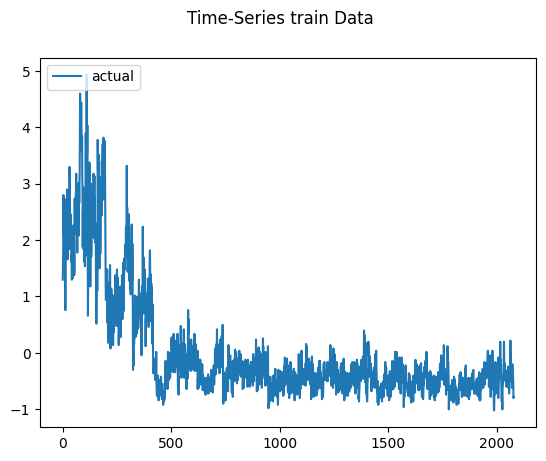

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3, 1000)           4108000   
                                                                 
 lstm_7 (LSTM)               (None, 500)               3002000   
                                                                 
 batch_normalization_9 (Bat  (None, 500)               2000      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 250)               125250    
                                                                 
 batch_normalization_10 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 120)              

2024-01-17 01:14:22.969934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:14:24.141258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:14:24.161901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:14:24.231594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:14:24.273043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:14:24.383741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:14:24.433410: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 14.
Epoch 22: early stopping
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_6_input (InputLayer)   [(None, 3, 26)]              0         []                            
                                                                                                  
 lstm_8_input (InputLayer)   [(None, 3, 1024)]            0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 120)                  7268850   ['lstm_6_input[0][0]']        
                                                                                                  
 sequential_6 (Sequential)   (None, 120)                  1126085   ['lstm_8_input[0][0]']        
         

2024-01-17 01:18:24.995867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:25.582289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:25.583458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:25.617099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:25.617141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:25.889320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:25.925917: I tensorflow/core/grappler/optimizers/cust

16/16 [==============================] - 4s 81ms/step
Test MAE: 21.364
Test RMSE: 29.061
Test sMAPE: 39.131
Test R Squared: 0.631
{'mae': 21.3644349528294, 'rmse': 29.060715130509557, 'smape': 39.13138859304704, 'r2': 0.6306610020323511}


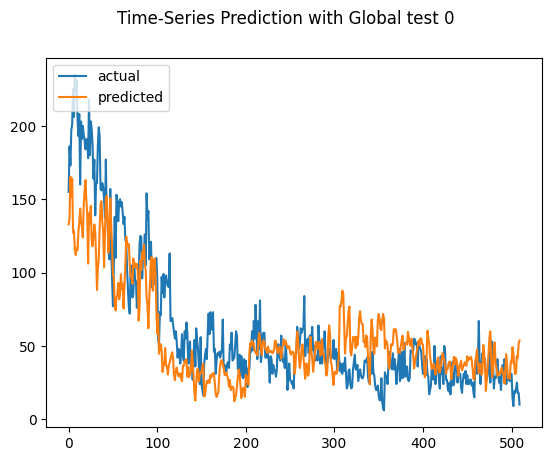

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 1000)           4108000   
                                                                 
 lstm_11 (LSTM)              (None, 500)               3002000   
                                                                 
 batch_normalization_15 (Ba  (None, 500)               2000      
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_16 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 120)              

2024-01-17 01:18:38.907532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:40.049040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:40.069747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:40.148780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:40.193593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:40.257244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:18:40.378204: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 7.
Epoch 15: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_10_input (InputLayer)  [(None, 3, 26)]              0         []                            
                                                                                                  
 lstm_12_input (InputLayer)  [(None, 3, 1024)]            0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 120)                  7268850   ['lstm_10_input[0][0]']       
                                                                                                  
 sequential_10 (Sequential)  (None, 120)                  1126085   ['lstm_12_input[0][0]']       
        

2024-01-17 01:21:41.790912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:21:42.540080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:21:42.565337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:21:42.603460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:21:42.853322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:21:42.857255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:21:42.859371: I tensorflow/core/grappler/optimizers/cust

16/16 [==============================] - 16s 570ms/step
Test MAE: 24.692
Test RMSE: 33.289
Test sMAPE: 48.560
Test R Squared: 0.515
{'mae': 24.69193002242668, 'rmse': 33.28863876725563, 'smape': 48.5596437166475, 'r2': 0.5153763046010389}


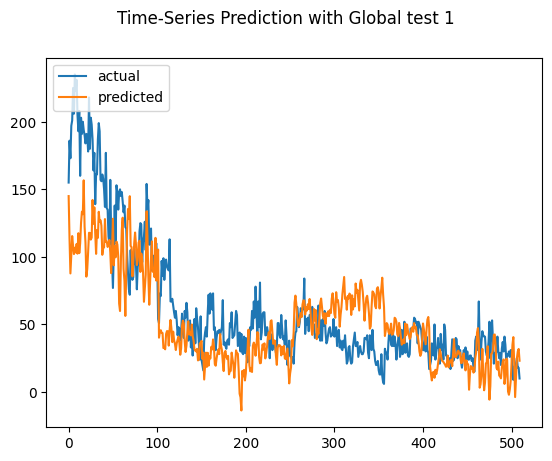

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 3, 1000)           4108000   
                                                                 
 lstm_15 (LSTM)              (None, 500)               3002000   
                                                                 
 batch_normalization_21 (Ba  (None, 500)               2000      
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_22 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 120)             

2024-01-17 01:22:12.427826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:22:13.879723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:22:13.905086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:22:14.030289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:22:14.112694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:22:14.235932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:22:14.303719: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_14_input (InputLayer)  [(None, 3, 26)]              0         []                            
                                                                                                  
 lstm_16_input (InputLayer)  [(None, 3, 1024)]            0         []                            
                                                                                                  
 sequential_13 (Sequential)  (None, 120)                  7268850   ['lstm_14_input[0][0]']       
                                                                                                  
 sequential_14 (Sequential)  (None, 120)                  1126085   ['lstm_16_input[0][0]']       
        

2024-01-17 01:24:43.571720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:24:44.264813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:24:44.265331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:24:44.296754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:24:44.297312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:24:44.919818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 01:24:44.947821: I tensorflow/core/grappler/optimizers/cust

16/16 [==============================] - 7s 172ms/step
Test MAE: 31.598
Test RMSE: 39.341
Test sMAPE: 50.410
Test R Squared: 0.323
{'mae': 31.59806406357709, 'rmse': 39.34065235167568, 'smape': 50.40972240407358, 'r2': 0.32314492996685074}


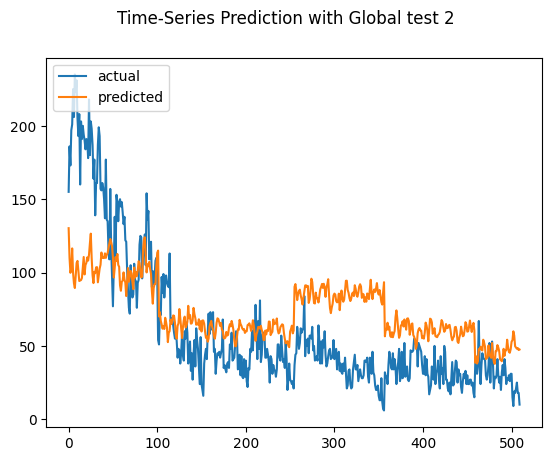

rmse : average=33.897, std=4.219
mae : average=25.885, std=4.262
smape : average=46.034, std=4.939
r2 : average=0.490, std=0.127


([33.89666874981362, 4.218732247373711],
 [25.884809679611056, 4.262160062806878],
 [46.03358490458938, 4.93868627806481],
 [0.48972741220008026, 0.12684618744946038])

In [17]:
set_all_seeds(1)

x_ar = train_X[:, :, :1024]
x_ar_test = test_X[:, :, :1024]
train_X = train_X[:, :, 1024:]
test_X = test_X[:, :, 1024:]

calculate_mean_std(lstm_layers, nn_layers, sequence, train_X.shape[2], dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion='joint', x_ar=x_ar, x_ar_test=x_ar_test)